In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sl
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [4]:
col=['S1','C1','S2','C2','S3','C3','S4','C4','S5','C5','class']
df_train=pd.read_csv("poker-hand-training-true.data",header=None,names=col)
df_test=pd.read_csv("poker-hand-testing.data",header=None,names=col)

In [5]:
df_train.head()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,class
0,3,1,3,10,3,11,3,12,3,13,9
1,1,10,1,11,1,12,1,13,1,1,9
2,1,1,1,13,2,4,2,3,1,12,0
3,3,12,3,2,3,11,4,5,2,5,1
4,1,9,4,6,1,4,3,2,3,9,1


In [6]:
x_train=df_train.iloc[:,:10]
y_train=df_train["class"]

x_test=df_test.iloc[:,:10]
y_test=df_test["class"]

# Transformed dataset

Feature Engineering

In [7]:
# Function to check if there are five consecutive 1s in a list
def check_consecutive_ones(lst):
    return (lst.rolling(window=5, min_periods=1).sum() == 5) & (lst.rolling(window=5, min_periods=1).max() == 1)

# Checking consecutive ness
def consecutive(dst):
    temp=dst.iloc[:, :13]
    temp[13]=temp.iloc[:,0]
    consecutive_ones_rows = temp.iloc[:, :14].apply(check_consecutive_ones, axis=1)
    # Assign value 1 to a new column for rows with consecutive five entries of 1
    dst[17] = consecutive_ones_rows.any(axis=1).astype(int)
    return dst

def transform_input(X):
  """
  Transforms the original 10-dimensions space into a 17-dimensions where the
  dimensions correspond to:
  0  - 12: Rank      0: ace 1: two ... 9: ten 10: jack ... 12: king
  13 - 16: Suite     13: hearts .. 16: lubs
  
  Each dimension keeps the number of times this particular rank or suite
  appeared in the hand.
  """  
  src = X.copy()
  
  dims = 13 + 4  # 13 ranks (ace thru king) + 4 suites (hearts, ...)
  dst= pd.DataFrame(0, index=np.arange(X.shape[0]), columns=np.arange(dims))
  
  suites = (0, 2, 4, 6, 8)
  # Negate the suite's values so that they don't overlap with the ranks
  # e.g. for (1) rank(ace) == suite(hearts)
  src.values[:, suites] *= -1
  
  attributes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, -1, -2 , -3, -4]
  for column, attribute in enumerate(attributes):
    tmp = src.copy()
    tmp[tmp != attribute] = 0
    tmp[tmp != 0] = 1
    dst[column] = tmp.sum(axis=1)
  dst=consecutive(dst) 
  mask = (dst[13] == 5) | (dst[14] == 5) | (dst[15] == 5) | (dst[16] == 5)
  dst[18] = (dst[[0, 9, 10, 11, 12]].eq(1).all(axis=1) & mask).astype(int)
  return dst  

In [8]:
transformed_x_train=transform_input(x_train)
transformed_x_test=transform_input(x_test)

Model Build

In [9]:
def model_run(model, x_train, y_train, x_test, y_test):
    # model fit
    model.fit(x_train, y_train)
   
    # predict value
    pred_val = model.predict(x_test)
    
    return pred_val

def accuracy(y_pred, y_true):
    classes_names = [str(label) for label in np.unique(y_true)]
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    #report= classification_report(y_true, y_pred,target_names=classes_names)
    report = classification_report(y_true, y_pred, target_names=classes_names)

    print("REPORT:", report)
    print("Confusion Matrix:\n", conf_matrix)
    
    # Normalize confusion matrix by dividing each cell by the total instances for the corresponding class
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    # Plot Confusion Matrix
    plt.figure(figsize=(4,4))
    plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title('Normalized Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes_names))
    plt.xticks(tick_marks, classes_names, rotation=45)
    plt.yticks(tick_marks, classes_names)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    plt.show()

Decision Tree classifier

Base Dataset

REPORT:               precision    recall  f1-score   support

           0       0.75      0.73      0.74     12493
           1       0.63      0.63      0.63     10599
           2       0.33      0.36      0.35      1206
           3       0.39      0.47      0.43       513
           4       0.27      0.33      0.30        93
           5       0.23      0.30      0.26        54
           6       0.13      0.17      0.14        36
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00         5

    accuracy                           0.66     25010
   macro avg       0.27      0.30      0.28     25010
weighted avg       0.66      0.66      0.66     25010

Confusion Matrix:
 [[9147 3089  154   54   11   37    1    0    0    0]
 [2919 6636  684  271   65   12   12    0    0    0]
 [ 118  595  439   36    3    0   14    1    0    0]
 [  29  186   39  243    1    0   13    2    0    0]
 [

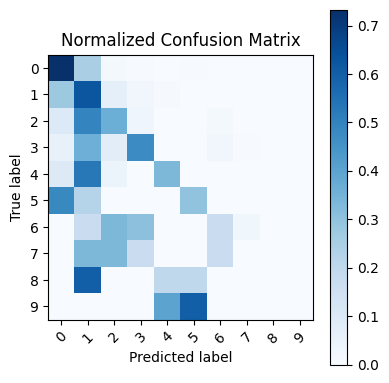

In [10]:
from sklearn.tree import DecisionTreeClassifier
dtc=DecisionTreeClassifier(random_state=42)
y_pred=model_run(dtc,x_train,y_train,x_test,y_test)
accuracy(y_pred,y_test)

On transform dataset

REPORT:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     12493
           1       1.00      1.00      1.00     10599
           2       1.00      1.00      1.00      1206
           3       1.00      1.00      1.00       513
           4       1.00      1.00      1.00        93
           5       1.00      1.00      1.00        54
           6       1.00      1.00      1.00        36
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5

    accuracy                           1.00     25010
   macro avg       1.00      1.00      1.00     25010
weighted avg       1.00      1.00      1.00     25010

Confusion Matrix:
 [[12493     0     0     0     0     0     0     0     0     0]
 [    0 10599     0     0     0     0     0     0     0     0]
 [    0     0  1206     0     0     0     0     0     0     0]
 [    0     0     0   513

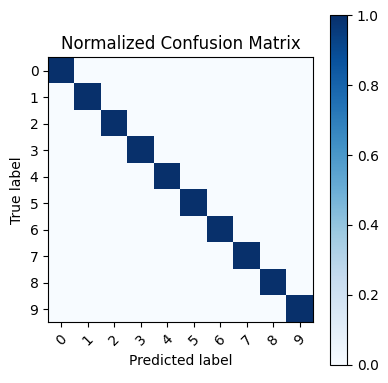

In [25]:
y_res=model_run(dtc,transformed_x_train,y_train,transformed_x_test,y_test)
accuracy(y_res,y_test)

KNN for base datset

REPORT:               precision    recall  f1-score   support

           0       0.66      0.75      0.70     12493
           1       0.58      0.56      0.57     10599
           2       0.32      0.11      0.17      1206
           3       0.30      0.09      0.14       513
           4       0.11      0.02      0.04        93
           5       0.00      0.00      0.00        54
           6       0.50      0.06      0.10        36
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00         5

    accuracy                           0.62     25010
   macro avg       0.25      0.16      0.17     25010
weighted avg       0.60      0.62      0.60     25010

Confusion Matrix:
 [[9321 3120   49    2    1    0    0    0    0    0]
 [4411 5907  188   82   10    1    0    0    0    0]
 [ 347  695  137   22    4    0    1    0    0    0]
 [  48  381   36   47    0    0    1    0    0    0]
 [

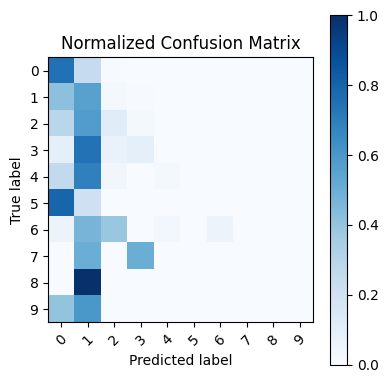

In [27]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
y_res=model_run(knn,x_train,y_train,x_test,y_test)
accuracy(y_res,y_test)

KNN

REPORT:               precision    recall  f1-score   support

           0       0.96      1.00      0.98     12493
           1       0.95      0.95      0.95     10599
           2       0.98      0.76      0.85      1206
           3       0.96      0.63      0.76       513
           4       0.92      1.00      0.96        93
           5       1.00      0.85      0.92        54
           6       1.00      0.31      0.47        36
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         5
           9       1.00      0.40      0.57         5

    accuracy                           0.96     25010
   macro avg       0.78      0.59      0.65     25010
weighted avg       0.96      0.96      0.96     25010

Confusion Matrix:
 [[12491     2     0     0     0     0     0     0     0     0]
 [  520 10078     1     0     0     0     0     0     0     0]
 [    0   290   916     0     0     0     0     0     0     0]
 [    0   185     3   325

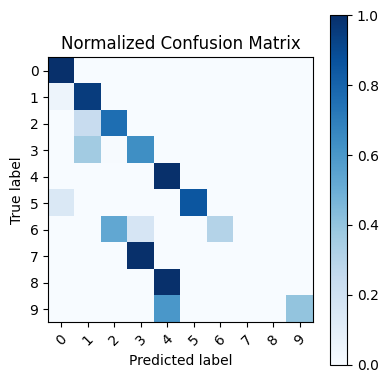

In [28]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
y_res=model_run(knn,transformed_x_train,y_train,transformed_x_test,y_test)
accuracy(y_res,y_test)

Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=50,class_weight='balanced_subsample', random_state=42)

BAse mOdel

REPORT:               precision    recall  f1-score   support

           0       0.79      0.92      0.85     12493
           1       0.73      0.72      0.72     10599
           2       0.56      0.03      0.05      1206
           3       0.90      0.09      0.16       513
           4       0.25      0.01      0.02        93
           5       1.00      0.41      0.58        54
           6       0.00      0.00      0.00        36
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00         5

    accuracy                           0.77     25010
   macro avg       0.42      0.22      0.24     25010
weighted avg       0.75      0.77      0.74     25010

Confusion Matrix:
 [[11457  1036     0     0     0     0     0     0     0     0]
 [ 2996  7583    15     2     3     0     0     0     0     0]
 [   21  1151    33     1     0     0     0     0     0     0]
 [    1   462     4    45

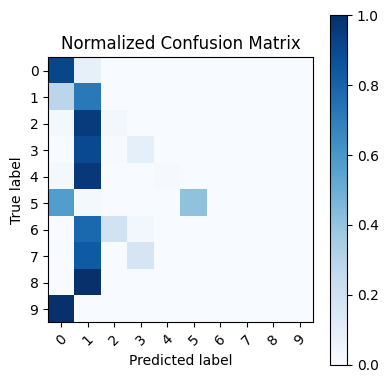

In [31]:
y_res=model_run(clf,x_train,y_train,x_test,y_test)
accuracy(y_res,y_test)

Transformed Data

REPORT:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     12493
           1       1.00      1.00      1.00     10599
           2       1.00      1.00      1.00      1206
           3       0.99      1.00      1.00       513
           4       0.95      1.00      0.97        93
           5       1.00      1.00      1.00        54
           6       1.00      0.92      0.96        36
           7       1.00      1.00      1.00         6
           8       0.00      0.00      0.00         5
           9       1.00      1.00      1.00         5

    accuracy                           1.00     25010
   macro avg       0.89      0.89      0.89     25010
weighted avg       1.00      1.00      1.00     25010

Confusion Matrix:
 [[12493     0     0     0     0     0     0     0     0     0]
 [    0 10599     0     0     0     0     0     0     0     0]
 [    0     0  1206     0     0     0     0     0     0     0]
 [    0     0     0   513

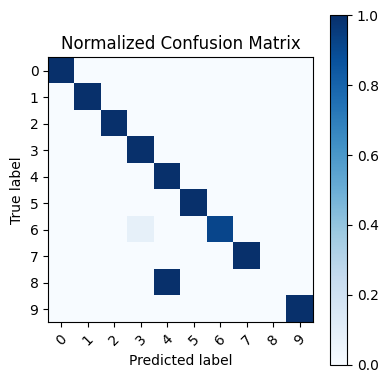

In [41]:
y_res=model_run(clf,transformed_x_train,y_train,transformed_x_test,y_test)
accuracy(y_res,y_test)

Naive Bayes 

In [33]:
from sklearn.naive_bayes import GaussianNB
nb= GaussianNB()

Base Data

REPORT:               precision    recall  f1-score   support

           0       0.50      1.00      0.67     12493
           1       0.00      0.00      0.00     10599
           2       0.00      0.00      0.00      1206
           3       0.00      0.00      0.00       513
           4       0.00      0.00      0.00        93
           5       0.00      0.00      0.00        54
           6       0.00      0.00      0.00        36
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00         5

    accuracy                           0.50     25010
   macro avg       0.05      0.10      0.07     25010
weighted avg       0.25      0.50      0.33     25010

Confusion Matrix:
 [[12493     0     0     0     0     0     0     0     0     0]
 [10599     0     0     0     0     0     0     0     0     0]
 [ 1206     0     0     0     0     0     0     0     0     0]
 [  513     0     0     0

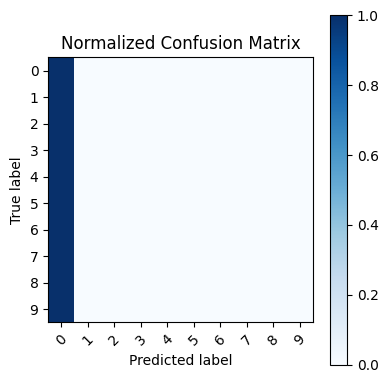

In [34]:
y_res=model_run(nb,x_train,y_train,x_test,y_test)
accuracy(y_res,y_test)

Transform Data

REPORT:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     12493
           1       0.86      1.00      0.92     10599
           2       0.00      0.00      0.00      1206
           3       0.00      0.00      0.00       513
           4       0.96      1.00      0.98        93
           5       0.00      0.00      0.00        54
           6       0.00      0.00      0.00        36
           7       0.00      0.00      0.00         6
           8       1.00      0.20      0.33         5
           9       1.00      1.00      1.00         5

    accuracy                           0.93     25010
   macro avg       0.48      0.42      0.42     25010
weighted avg       0.87      0.93      0.89     25010

Confusion Matrix:
 [[12493     0     0     0     0     0     0     0     0     0]
 [    0 10599     0     0     0     0     0     0     0     0]
 [    0  1206     0     0     0     0     0     0     0     0]
 [    0   513     0     0

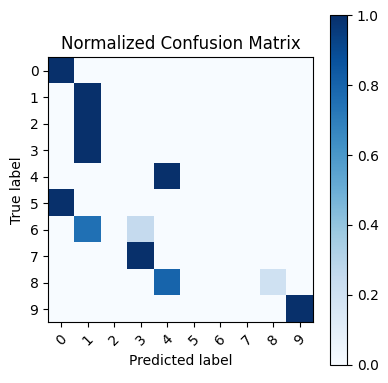

In [35]:
y_res=model_run(nb,transformed_x_train,y_train,transformed_x_test,y_test)
accuracy(y_res,y_test)

ADABOOST

In [36]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100, random_state=42)


BASE

REPORT:               precision    recall  f1-score   support

           0       0.52      0.31      0.39     12493
           1       0.48      0.08      0.13     10599
           2       0.00      0.00      0.00      1206
           3       0.00      0.00      0.00       513
           4       0.00      0.00      0.00        93
           5       0.00      0.00      0.00        54
           6       0.00      0.00      0.00        36
           7       0.00      0.17      0.00         6
           8       0.00      0.80      0.00         5
           9       0.00      0.00      0.00         5

    accuracy                           0.19     25010
   macro avg       0.10      0.14      0.05     25010
weighted avg       0.46      0.19      0.25     25010

Confusion Matrix:
 [[3901  687    0    0    0    0    0 2075 5830    0]
 [3076  797    0    0    0    0    0 1666 5060    0]
 [ 345  115    0    0    0    0    0  174  572    0]
 [ 135   46    0    0    0    0    0   57  275    0]
 [

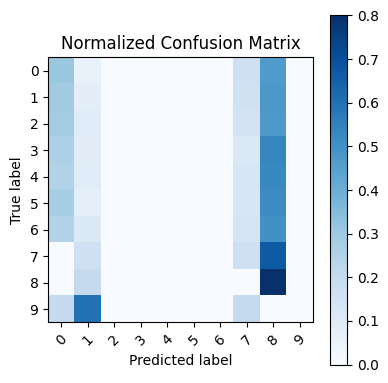

In [37]:
y_res=model_run(ada,x_train,y_train,x_test,y_test)
accuracy(y_res,y_test)

TRANSFORMED

REPORT:               precision    recall  f1-score   support

           0       0.52      1.00      0.69     12493
           1       0.79      0.08      0.14     10599
           2       0.00      0.00      0.00      1206
           3       0.00      0.00      0.00       513
           4       1.00      1.00      1.00        93
           5       1.00      1.00      1.00        54
           6       0.00      0.00      0.00        36
           7       0.00      0.00      0.00         6
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5

    accuracy                           0.54     25010
   macro avg       0.53      0.51      0.48     25010
weighted avg       0.60      0.54      0.41     25010

Confusion Matrix:
 [[12493     0     0     0     0     0     0     0     0     0]
 [ 9787   812     0     0     0     0     0     0     0     0]
 [ 1023   183     0     0     0     0     0     0     0     0]
 [  475    38     0     0

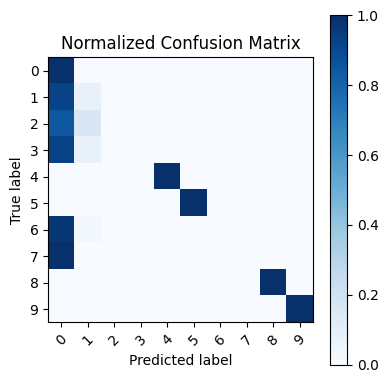

In [38]:
y_res=model_run(ada,transformed_x_train,y_train,transformed_x_test,y_test)
accuracy(y_res,y_test)

In [33]:
uni=pd.read_csv("unique_poker.csv")

In [34]:
uni_x=uni.iloc[:,:10]
uni_y=uni.iloc[:,10]

In [36]:
uni_x=transform_input(uni_x)

In [37]:
uni_x[uni_y==9]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
126490,1,0,0,0,0,0,0,0,0,1,1,1,1,5,0,0,0,1,1
2069613,1,0,0,0,0,0,0,0,0,1,1,1,1,0,5,0,0,1,1
2543450,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,5,0,1,1
2598167,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,5,1,1


REPORT:               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1302540
           1       1.00      1.00      1.00   1098240
           2       1.00      1.00      1.00    123552
           3       0.99      1.00      1.00     54912
           4       1.00      1.00      1.00     10200
           5       1.00      1.00      1.00      5108
           6       1.00      0.90      0.95      3744
           7       1.00      1.00      1.00       624
           8       1.00      0.47      0.64        36
           9       1.00      1.00      1.00         4

    accuracy                           1.00   2598960
   macro avg       1.00      0.94      0.96   2598960
weighted avg       1.00      1.00      1.00   2598960

Confusion Matrix:
 [[1302540       0       0       0       0       0       0       0       0
        0]
 [      0 1098240       0       0       0       0       0       0       0
        0]
 [      0       2  123550       0       0   

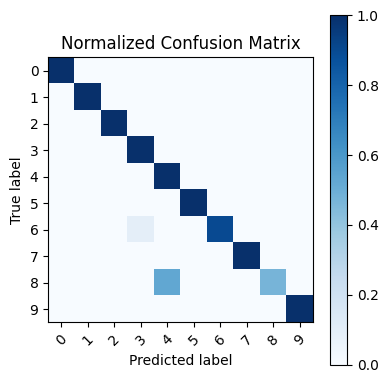

In [42]:
y_pred=clf.predict(uni_x)
accuracy(y_pred,uni_y)

Create 26 lakhs unique sample

In [17]:
import pandas as pd
import itertools

# Define the deck of 52 cards
suits = ['Hearts', 'Spades', 'Diamonds', 'Clubs']
ranks = ['Ace', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'Jack', 'Queen', 'King']
deck = list(itertools.product(suits, ranks))

# Define a function to determine the poker hand
def determine_poker_hand(cards):
    suits = [card[0] for card in cards]
    ranks = [card[1] for card in cards]
    rank_count = {rank: ranks.count(rank) for rank in set(ranks)}
    is_flush = len(set(suits)) == 1
    sorted_ranks = sorted([int(rank) if rank.isdigit() else 11 if rank == 'Jack' else 12 if rank == 'Queen' else 13 if rank == 'King' else 1 for rank in ranks])  # Sort ranks by numerical value
    is_straight = len(set(sorted_ranks)) == 5 and (sorted_ranks[-1] - sorted_ranks[0] == 4)
    if is_flush and sorted_ranks == [1, 10, 11, 12, 13]:
        return 'Royal flush'
    if is_flush and is_straight:
        return 'Straight flush'
    if 4 in rank_count.values():
        return 'Four of a kind'
    if set(rank_count.values()) == {2, 3}:
        return 'Full house'
    if is_flush:
        return 'Flush'
    if is_straight or sorted_ranks == [1, 10, 11, 12, 13]:
        return 'Straight'
    if 3 in rank_count.values():
        return 'Three of a kind'
    if list(rank_count.values()).count(2) == 2:
        return 'Two pairs'
    if 2 in rank_count.values():
        return 'One pair'
    return 'Nothing in hand'

# Generate all permutations of 5 cards and save them along with the poker hand category
poker_hands = []
for perm in itertools.combinations(deck, 5):
    poker_hand = determine_poker_hand(perm)
    row = [card[0] for card in perm] + [card[1] for card in perm] + [poker_hand]
    poker_hands.append(row)

# Create a DataFrame from the generated data and save it as a CSV file
df = pd.DataFrame(poker_hands, columns=['Card1_Suit', 'Card2_Suit', 'Card3_Suit', 'Card4_Suit', 'Card5_Suit',
                                         'Card1_Rank', 'Card2_Rank', 'Card3_Rank', 'Card4_Rank', 'Card5_Rank',
                                         'Poker_Hand'])
df.to_csv('poker_hand_dataset.csv', index=False)

print("CSV file 'poker_hand_dataset.csv' generated successfully.")


CSV file 'poker_hand_dataset.csv' generated successfully.
